## Spread Trading Strategy - Anshul Agrawal ( 12211984 )

### Introduction
    1) The pair of ETFs chosen for this strategy is PBE (Invesco Dynamic Biotechnology & Genome ETF) and XBI (ProShares ETF). 
    2) The data for back testing the return spread trading strategy is from 2nd December 2016 to 31st December 2018.
    3) The strategy would enter in a position in the above ETFs during the calendar month and all positions are closed at the end of the month.
    4) The spread is PBE returns minus the XBI returns.

In [211]:
%matplotlib inline

In [212]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import quandl
import functools
from scipy import stats

In [213]:
quandl.ApiConfig.api_key = "_pYyj-4dy4nxthKZ9hr5"
@functools.lru_cache(maxsize=16)
def fetch_quandl(my_securities,start_date,end_date):
    print("Fetching from Quandl")
    qdata = quandl.get(list(my_securities), returns="pandas",start_date=start_date, end_date=end_date)
    return qdata

In [214]:
raw_data = fetch_quandl(('EOD/PBE', "EOD/XBI"),"2016-12-02","2018-12-31")

Fetching from Quandl


### Cleaning the data

In [135]:
def clean_quandl_columns(dataframe):
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('/')
        replacement_columns[c] = asset+":"+variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data

### Return Spread Time series statistical inferences

#### Testing the return spread data's mean for 0 mean. 

The t-statistic is -0.819 and the p-value is 0.413.


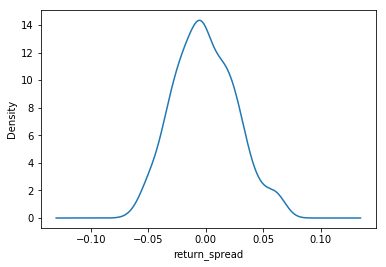

In [158]:
df = clean_quandl_columns(raw_data)
df['PBE_Daily_Return'] = (df['PBE:Adj_Close']/df['PBE:Adj_Close'].shift(M)) - 1
df['XBI_Daily_Return'] = (df['XBI:Adj_Close']/df['XBI:Adj_Close'].shift(M)) - 1
df['return_spread'] = df['PBE_Daily_Return'] - df['XBI_Daily_Return']
df = df.loc["2017-01-01":"2018-12-31"]
df['return_spread'].plot.density()
plt.xlabel('return_spread')
one_sample = stats.ttest_1samp(df['return_spread'], 0.0)
print("The t-statistic is %.3f and the p-value is %.3f." % one_sample)

#### Conclusion
    1) From the above one sample t-test (95% confidence) we can conclude that we cannot reject the null hypothesis of return spread mean being  0 as we obtain a high p-value. So the population return spread mean is 0.     

#### Daily Dollar Volume Plot of the ETFs

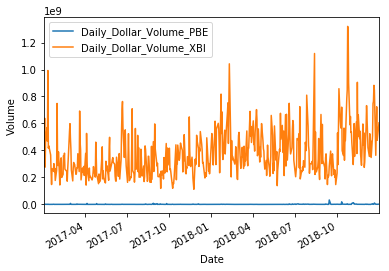

In [215]:
df['Daily_Dollar_Volume_PBE'] = (df['PBE:Adj_Close']*df['PBE:Volume'])
df['Daily_Dollar_Volume_XBI'] = (df['XBI:Adj_Close']*df['XBI:Volume'])
df.plot(y=['Daily_Dollar_Volume_PBE','Daily_Dollar_Volume_XBI'])
plt.ylabel('Volume')
plt.show()
ax.legend()
plt.show()

##### Conclusion
    1) From the above plot we observe that PBI is the less liquid ETF

### Spread Trading Strategy Function ( function arguments - g_multiple, j_multiple, s, M ) 

     1) g_multiple is the number of standarad deviations away from the mean are the extreme levels for deciding entry and exit points. Assume a short position in the spread if the spread is more than (mean + g_multiple*standard_deviation) and a long position if the return spread is below the (mean - g_multiple * standard_deviation).
     
    2) j_multiple is used for determining the exit criteria from the position already taken in the market.These levels are (mean + j_multiple * standard_deviation) for exiting the short positions and ((mean - j_multiple * standard_deviation) for exiting the long position.
    
    3) s is the stop loss parameter which is a percentage of the gross traded cash determined at the time of entry into a spread trade.
    
    4) M is the number of days used for calculating the returns.

In [216]:
def Spread_Trading_Strategy_PnL(g_multiple,j_multiple,s,M):
    
    # g_multiple is the multiple of standard deviation for g parameter
    # j_multiple is the multiple of standard deviation for j parameter
    
    df = clean_quandl_columns(raw_data)
    
    df['Daily_Dollar_Volume_PBE'] = (df['PBE:Adj_Close']*df['PBE:Volume'])
    df['Daily_Dollar_Volume_XBI'] = (df['XBI:Adj_Close']*df['XBI:Volume'])
    
    # Our Current Holding of XBI and PBE ETFs in the market
    # Dollar Notional Size from the less liquid ETF (PBI in this case)
    df['Nt'] = df['Daily_Dollar_Volume_PBE'].rolling(15).median()
    
    # Computing M-day Returns and Returns Spread
    df['PBE_Daily_Return'] = (df['PBE:Adj_Close']/df['PBE:Adj_Close'].shift(M)) - 1
    df['XBI_Daily_Return'] = (df['XBI:Adj_Close']/df['XBI:Adj_Close'].shift(M)) - 1
    df['return_spread'] = df['PBE_Daily_Return'] - df['XBI_Daily_Return']                                            # x-y
    
    # Setting the levels of decision of entry and exit
    mu = 0
    std = df['return_spread'].std()
    gu = mu + g_multiple*std
    gl = mu + j_multiple*std
    jl = mu - g_multiple*std
    ju = mu - j_multiple*std
    
    #Slicing the data frame for the required period since our potential trade can start from 1st January 2017.
    df=df.loc["2017-01-01":"2018-12-31"]
    df=df[['PBE:Volume','PBE:Adj_Close','Daily_Dollar_Volume_PBE','PBE_Daily_Return','XBI:Volume','XBI:Adj_Close',
       'Daily_Dollar_Volume_XBI','XBI_Daily_Return','return_spread','Nt']]
    
    # Creating a Flag to check for month end date index
    x = pd.DataFrame(df.index,index = df.index).shift(-1)
    df['ME_Flag']=(x["Date"].dt.month != df.index.month)
    del x
    
    df["Final_Position"] = 0 * len(df.index)    # Final Position column indicates our current net market position of the spread.
    Final_Position = 0
    
    #Entry/Exit Criteria which updates the Final Spread Position in the market
    for i in range(len(df.index)):
        
        # At month end all the positions should be closed
        if (df.iat[i,10] == True):     
            Final_Position = 0
            df.iat[i,11] = Final_Position
            
            continue
            
        if ((df.iat[i,8] > gu) & (Final_Position != -1)):
            Final_Position = -1
            
        if ((df.iat[i,8] < gl) & (Final_Position == -1)):
            Final_Position = 0
            
        if ((df.iat[i,8] < jl) & (Final_Position != 1)):
            Final_Position = 1
            
        if ((df.iat[i,8] > ju) & (Final_Position == 1)):
            Final_Position = 0
            
        df.iat[i,11] = Final_Position
            
   # Spread Trade Quantity column indicates the spread trade quantity to be executed in the market to 
   # achieve the Final Position
    
    df['Spread_Trade_Quantity'] = df['Final_Position'] - df['Final_Position'].shift(1).fillna(0)
    df['Product_Position'] = df['Final_Position']*df['Spread_Trade_Quantity']
    
    df['PBE_shares_position'] = np.nan
    df['XBI_shares_position'] = np.nan
    df.loc[df['Product_Position'] != 0, 'PBE_shares_position'] = np.floor(df['Final_Position'] \
                                                                          * df['Nt']/(100*df['PBE:Adj_Close']))
    df.loc[df['Product_Position'] != 0,'XBI_shares_position'] = np.floor(-1 * df['Final_Position']\
                                                                         * df['Nt']/(100*df['XBI:Adj_Close']))
    df['PBE_shares_position'] = df['PBE_shares_position'].fillna(method = 'ffill')
    df['XBI_shares_position'] = df['XBI_shares_position'].fillna(method = 'ffill')
    df.loc[df['Final_Position'] == 0,'PBE_shares_position'] = 0
    df.loc[df['Final_Position'] == 0,'XBI_shares_position'] = 0
    
    # Stop Loss Level is determined on the basis of a proportion s of gross traded cash on trade date
    df['Stop_Loss_Level'] = np.nan
    df.loc[(df['Product_Position'] != 0) & (df['Final_Position'] != 0),'Stop_Loss_Level'] =  \
                -s * (abs(df['PBE_shares_position'])*df['PBE:Adj_Close'] + abs(df['XBI_shares_position'])*df['XBI:Adj_Close'])
    df['Stop_Loss_Level'] = df['Stop_Loss_Level'].fillna(method = 'ffill')
    
    # Initial Position column to compute the market value of our position when we assume a position in the market
    # Unrealized MtM column is the profit/loss accumulated in the position until we unwind the position.
    df['Initial_Position'] = np.nan
    df.loc[(df['Final_Position'] != 0)&(df['Spread_Trade_Quantity'] != 0),'Initial_Position'] = \
            (df['PBE_shares_position'])*df['PBE:Adj_Close'] + (df['XBI_shares_position'])*df['XBI:Adj_Close']
    df['Initial_Position'] = df['Initial_Position'].fillna(method = 'ffill')
    df['Net_Value'] = df['PBE_shares_position']*df['PBE:Adj_Close'] + df['XBI_shares_position']*df['XBI:Adj_Close']
    df['Unrealized_MtM'] = df['Net_Value'] - df['Initial_Position']
    
    # Determining if a stoploss level was hit in the month, in such case trading is stopped for the rest of the month
    df['stoploss_hit_indicator'] = 0 * len(df.index)
    
    index_label = df[((df['Unrealized_MtM'] < df['Stop_Loss_Level']))].index.tolist()

    for i in range(len(df.index)):
        if df.index[i] in index_label:
            df['stoploss_hit_indicator'][i] = df.index[i].month

    for i in range(len(df.index)-1):
        if df.index[i+1].month == df['stoploss_hit_indicator'][i]:
            df['stoploss_hit_indicator'][i+1] = df.index[i+1].month

    #Updating the Final_Position,Spread Trade Quantity,Product Position and share positions columns to 
    #account for the stoploss_hit_indicator
    
    df.loc[df['stoploss_hit_indicator'] != 0,"Final_Position"] = 0
    df['Spread_Trade_Quantity'] = df['Final_Position'] - df['Final_Position'].shift(1).fillna(0)
    df['Product_Position'] = df['Final_Position']*df['Spread_Trade_Quantity']
    df.loc[df['Product_Position'] != 0, 'PBE_shares_position'] = np.floor(df['Final_Position'] \
                                                                          * df['Nt']/(100*df['PBE:Adj_Close']))
    df.loc[df['Product_Position'] != 0,'XBI_shares_position'] = np.floor(-1 * df['Final_Position'] \
                                                                         * df['Nt']/(100*df['XBI:Adj_Close']))
    df.loc[df['Final_Position'] == 0 , 'PBE_shares_position'] = 0
    df.loc[df['Final_Position'] == 0, 'XBI_shares_position'] = 0
    df.loc[(df['Final_Position'] == 0) & (df['Spread_Trade_Quantity'] == 0),'Stop_Loss_Level'] = 0
    df.loc[(df['Final_Position'] == 0) & (df['Spread_Trade_Quantity'] == 0),'Initial_Position'] = 0
    df.loc[(df['Final_Position'] == 0) & (df['Spread_Trade_Quantity'] == 0),'Net_Value'] = 0
    df['PBE_shares_position'] = df['PBE_shares_position'].fillna(method = 'ffill')
    df['XBI_shares_position'] = df['XBI_shares_position'].fillna(method = 'ffill')
    
    # Quantity of PBE and XBI shares that need to be traded to achieve the current market position
    df['PBE_shares_position_diff'] = df['PBE_shares_position']-df['PBE_shares_position'].shift(1).fillna(0)
    df['XBI_shares_position_diff'] = df['XBI_shares_position']-df['XBI_shares_position'].shift(1).fillna(0)
    df['Initial_Position'] = df['Initial_Position'].fillna(method = 'ffill')
    df['Unrealized_MtM'] = df['Net_Value'] - df['Initial_Position']
    
    # Computing the PnL of the strategy
    df['CashI/O'] = 0.0 * len(df.index)
    df['CashI/O'] = -df['PBE_shares_position_diff']*df['PBE:Adj_Close']-df['XBI_shares_position_diff']*df['XBI:Adj_Close']
    df['PnL'] = df['CashI/O'].cumsum()
    
    Final_Profit_from_strategy = df['PnL'][-1] 
    
    return (Final_Profit_from_strategy)

### Function Parameter Optimization

#### Trying different combinations of parameters to get an optimized set of parameters over the given dataset. 
    1) Keeping 3 of the parameters constant, I ran the above function for various values of the 4th parameter to get an idea of good range of the limited range of values I need to run for a constrained grid search. 

#### Optimal Range of M - Return Days

C:\Users\Anshul\Anaconda3\envs\Quant_Trading_Strategies\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Anshul\Anaconda3\envs\Quant_Trading_Strategies\lib\site-packages\ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Maximum_Profit 1158.3984575801187
Optimum_Return_Days 7


Text(0.5,1,'Optimal Return Days')

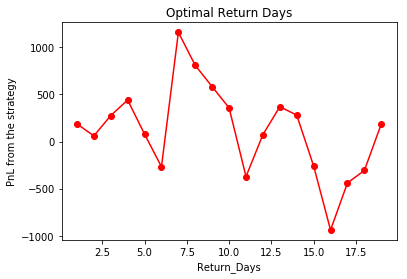

In [217]:
g_multiple = 1.2
j_multiple = 0.5
s = 0.014

Return_Days = []
list_M = np.arange(1,20,1)

for M in list_M:
    Return_Days.append(Spread_Trading_Strategy_PnL(g_multiple,j_multiple,s,M))

Max_Profit = np.max(Return_Days)
                       
print("Maximum_Profit",Max_Profit)
                       
for i in range(len(Return_Days)):
    if Return_Days[i] == Max_Profit:
        index = Return_Days[i]
        break
            
print('Optimum_Return_Days',list_M[i])
plt.plot(list_M, Return_Days,'ro',linestyle='-')
plt.xlabel('Return_Days')
plt.ylabel('PnL from the strategy')
plt.title('Optimal Return Days')

#### Conclusion
    1) From the above plot it is safe to assume that the profit from the strategy is maximised when the optimal M value is between 1 and 10.

#### Optimal range of Stop_Loss Parameter (s) 

C:\Users\Anshul\Anaconda3\envs\Quant_Trading_Strategies\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Anshul\Anaconda3\envs\Quant_Trading_Strategies\lib\site-packages\ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Maximum_Profit 406.6102399553256
Optimum_Stop_Loss_Level 0.007


Text(0.5,1,'Optimal Stop Loss Level')

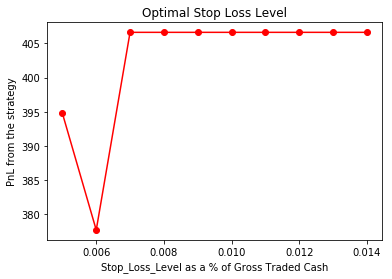

In [176]:
g_multiple = 2
j_multiple = 1
M = 7

StopLossLevel = []
list_s = np.arange(0.005,0.015,0.001)
for s in list_s:
    StopLossLevel.append(Spread_Trading_Strategy_PnL(g_multiple,j_multiple,s,M))

Max_Profit = np.max(StopLossLevel)

print("Maximum_Profit", Max_Profit)

for i in range(len(StopLossLevel)):
    if StopLossLevel[i] == Max_Profit:
        index = StopLossLevel[i]
        break
            
print('Optimum_Stop_Loss_Level',list_s[i])
plt.plot(list_s, StopLossLevel,'ro',linestyle='-')
plt.xlabel('Stop_Loss_Level as a % of Gross Traded Cash')
plt.ylabel('PnL from the strategy')
plt.title('Optimal Stop Loss Level')

#### Conclusion
    1) The above plot for stop loss level and PnL indicates that the stop loss effect doesn't kick in for values of s being 0.007 and above.This implies that the stop loss doesn't have any effect on the P&L if it is 0.007 or higher as stop loss parameter is never hit. StopLoss value of 0.006 and lesser makes impact on the trading activity based on the ETF spread returns. 

#### Optimal Range of g_multiple parameter (g_multiple)

C:\Users\Anshul\Anaconda3\envs\Quant_Trading_Strategies\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Anshul\Anaconda3\envs\Quant_Trading_Strategies\lib\site-packages\ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Maximum_Profit 1037.4789807232737
Optimum_gLevel 1.25


Text(0.5,1,'Optimal gLevel')

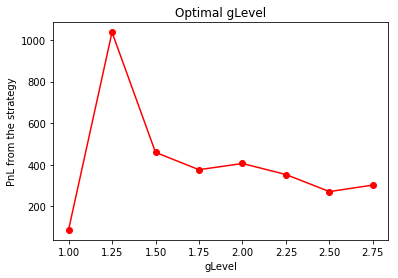

In [182]:
j_multiple = 1
s = 0.007
M = 7

gLevel = []
g = np.arange(1,3,0.25)
for g_multiple in g:
    gLevel.append(Spread_Trading_Strategy_PnL(g_multiple,j_multiple,s,M))
       
Max_Profit = np.max(gLevel)

print("Maximum_Profit",Max_Profit)

for i in range(len(gLevel)):
    if gLevel[i] == Max_Profit:
        index = gLevel[i]
        break
            
print('Optimum_gLevel',g[i])

plt.plot(g, gLevel,'ro',linestyle='-')
plt.xlabel('gLevel')
plt.ylabel('PnL from the strategy')
plt.title('Optimal gLevel')

#### Conclusion
    1) From the above plot we can comforatbly say the optimal g_multiple level lies in between 1 and 2. So the optimal g would lie between 1*std and 2*std. The range seems reasonable because it allows for ample trading opportunities to generate P&L given the return spreads.

#### Optimal Range of j_multiple 

Maximum_Profit 358.52847687506073
Optimum_jLevel 0.0


Text(0.5,1,'Optimal jLevel')

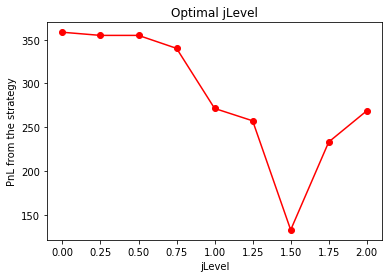

In [181]:
g_multiple = 2.5
s = 0.007
M = 7

jLevel = []
j = np.arange(0,2.25,0.25)
for j_multiple in j:
    jLevel.append(Spread_Trading_Strategy_PnL(g_multiple,j_multiple,s,M))
       
Max_Profit = np.max(jLevel)

print("Maximum_Profit",Max_Profit)

for i in range(len(jLevel)):
    if jLevel[i] == Max_Profit:
        index = jLevel[i]
        break
            
print('Optimum_jLevel',j[i])

plt.plot(j, jLevel,'ro',linestyle='-')
plt.xlabel('jLevel')
plt.ylabel('PnL from the strategy')
plt.title('Optimal jLevel')

#### Conclusion
    1) From the above plot we can conclude that the j_multiple should lie between 0 and 1.25 given the g_multiple of 2.5. This seems consistent because given the volatility of returns , the position is not unwound quickly leading to greater chances of profit from the strategy.

#### Based on the above observations I run a constrained ( limited range of parameter values ) grid search. 

####  Below code snippet takes some hours to run to get the final output. 

In [185]:
results,val = [],[]
for M in [1,2,3,5,7,10]:
    for g_multiple in np.arange(1,2,0.1):
        for j_multiple in np.arange(0,1.5,0.25):
            for s in np.arange(0.00,0.007,0.001):
                a = Spread_Trading_Strategy_PnL(g_multiple,j_multiple,s,M)
                print("g_multiple " + str(g_multiple) +  " j_multiple " + str(j_multiple) +  " SL " + str(s) + " M " \
                      + str(M) + " PnL " + str(a))
                results.append(a)
                val.append([g_multiple,j_multiple,s,M])

C:\Users\Anshul\Anaconda3\envs\Quant_Trading_Strategies\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Anshul\Anaconda3\envs\Quant_Trading_Strategies\lib\site-packages\ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


g_multiple 1.0 j_multiple 0.0 SL 0.0 M 1 PnL 233.9218542699441
g_multiple 1.0 j_multiple 0.0 SL 0.001 M 1 PnL 90.14862314300399
g_multiple 1.0 j_multiple 0.0 SL 0.002 M 1 PnL 245.86041944700492
g_multiple 1.0 j_multiple 0.0 SL 0.003 M 1 PnL 371.7694842550868
g_multiple 1.0 j_multiple 0.0 SL 0.004 M 1 PnL 669.5721565660674
g_multiple 1.0 j_multiple 0.0 SL 0.005 M 1 PnL 505.2961810366255
g_multiple 1.0 j_multiple 0.0 SL 0.006 M 1 PnL 228.9758815700452
g_multiple 1.0 j_multiple 0.25 SL 0.0 M 1 PnL 252.007553848915
g_multiple 1.0 j_multiple 0.25 SL 0.001 M 1 PnL 175.93604944772733
g_multiple 1.0 j_multiple 0.25 SL 0.002 M 1 PnL 361.58040540629236
g_multiple 1.0 j_multiple 0.25 SL 0.003 M 1 PnL 476.14032152759637
g_multiple 1.0 j_multiple 0.25 SL 0.004 M 1 PnL 701.4232047669752
g_multiple 1.0 j_multiple 0.25 SL 0.005 M 1 PnL 535.3223963483892
g_multiple 1.0 j_multiple 0.25 SL 0.006 M 1 PnL 275.71683970455433
g_multiple 1.0 j_multiple 0.5 SL 0.0 M 1 PnL 408.07107758630855
g_multiple 1.0 j_mu

g_multiple 1.2000000000000002 j_multiple 1.0 SL 0.006 M 1 PnL 264.0913450386479
g_multiple 1.2000000000000002 j_multiple 1.25 SL 0.0 M 1 PnL 152.73242954390025
g_multiple 1.2000000000000002 j_multiple 1.25 SL 0.001 M 1 PnL 152.73242954390025
g_multiple 1.2000000000000002 j_multiple 1.25 SL 0.002 M 1 PnL 152.73242954390025
g_multiple 1.2000000000000002 j_multiple 1.25 SL 0.003 M 1 PnL 152.73242954390025
g_multiple 1.2000000000000002 j_multiple 1.25 SL 0.004 M 1 PnL 152.73242954390025
g_multiple 1.2000000000000002 j_multiple 1.25 SL 0.005 M 1 PnL 110.43357839983673
g_multiple 1.2000000000000002 j_multiple 1.25 SL 0.006 M 1 PnL 245.3225930447261
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.0 M 1 PnL -178.31296978954742
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.001 M 1 PnL -237.49724868382145
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.002 M 1 PnL -164.79621161457408
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.003 M 1 PnL -126.67873347895102
g_multiple 1.3000000000

g_multiple 1.5000000000000004 j_multiple 0.25 SL 0.002 M 1 PnL 105.99570213330844
g_multiple 1.5000000000000004 j_multiple 0.25 SL 0.003 M 1 PnL 177.83629287837812
g_multiple 1.5000000000000004 j_multiple 0.25 SL 0.004 M 1 PnL 142.905671667987
g_multiple 1.5000000000000004 j_multiple 0.25 SL 0.005 M 1 PnL 252.4632087377131
g_multiple 1.5000000000000004 j_multiple 0.25 SL 0.006 M 1 PnL 265.19190035963675
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.0 M 1 PnL 120.349836079733
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.001 M 1 PnL 120.349836079733
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.002 M 1 PnL 178.8034681483332
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.003 M 1 PnL 163.62436201614582
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.004 M 1 PnL 128.69374080575471
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.005 M 1 PnL 246.7682679696245
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.006 M 1 PnL 259.49695959154815
g_multiple 1.5000000000000004 j_mu

g_multiple 1.7000000000000006 j_multiple 0.75 SL 0.006 M 1 PnL 474.8298949989685
g_multiple 1.7000000000000006 j_multiple 1.0 SL 0.0 M 1 PnL 111.9832893209923
g_multiple 1.7000000000000006 j_multiple 1.0 SL 0.001 M 1 PnL 111.9832893209923
g_multiple 1.7000000000000006 j_multiple 1.0 SL 0.002 M 1 PnL 111.9832893209923
g_multiple 1.7000000000000006 j_multiple 1.0 SL 0.003 M 1 PnL 111.9832893209923
g_multiple 1.7000000000000006 j_multiple 1.0 SL 0.004 M 1 PnL 177.29293073822646
g_multiple 1.7000000000000006 j_multiple 1.0 SL 0.005 M 1 PnL 295.36745790209625
g_multiple 1.7000000000000006 j_multiple 1.0 SL 0.006 M 1 PnL 474.8298949989685
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.0 M 1 PnL 147.70398789510637
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.001 M 1 PnL 147.70398789510637
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.002 M 1 PnL 147.70398789510637
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.003 M 1 PnL 147.70398789510637
g_multiple 1.7000000000000006 j_m

g_multiple 1.0 j_multiple 0.0 SL 0.003 M 2 PnL 787.5614910961399
g_multiple 1.0 j_multiple 0.0 SL 0.004 M 2 PnL 794.8849713585437
g_multiple 1.0 j_multiple 0.0 SL 0.005 M 2 PnL 744.9173355187409
g_multiple 1.0 j_multiple 0.0 SL 0.006 M 2 PnL 634.3555517897589
g_multiple 1.0 j_multiple 0.25 SL 0.0 M 2 PnL 260.2000084001925
g_multiple 1.0 j_multiple 0.25 SL 0.001 M 2 PnL 243.2438088237309
g_multiple 1.0 j_multiple 0.25 SL 0.002 M 2 PnL 541.3911637270971
g_multiple 1.0 j_multiple 0.25 SL 0.003 M 2 PnL 751.9269401923798
g_multiple 1.0 j_multiple 0.25 SL 0.004 M 2 PnL 698.8903640615304
g_multiple 1.0 j_multiple 0.25 SL 0.005 M 2 PnL 648.9227282217275
g_multiple 1.0 j_multiple 0.25 SL 0.006 M 2 PnL 538.3609444927456
g_multiple 1.0 j_multiple 0.5 SL 0.0 M 2 PnL 287.5093014581903
g_multiple 1.0 j_multiple 0.5 SL 0.001 M 2 PnL 348.43429698962836
g_multiple 1.0 j_multiple 0.5 SL 0.002 M 2 PnL 604.5674137995834
g_multiple 1.0 j_multiple 0.5 SL 0.003 M 2 PnL 644.2806801950287
g_multiple 1.0 j_mult

g_multiple 1.2000000000000002 j_multiple 1.25 SL 0.001 M 2 PnL -201.89324361794752
g_multiple 1.2000000000000002 j_multiple 1.25 SL 0.002 M 2 PnL -212.44688409259652
g_multiple 1.2000000000000002 j_multiple 1.25 SL 0.003 M 2 PnL -175.16117029512498
g_multiple 1.2000000000000002 j_multiple 1.25 SL 0.004 M 2 PnL -94.8157120565429
g_multiple 1.2000000000000002 j_multiple 1.25 SL 0.005 M 2 PnL -98.99420995314176
g_multiple 1.2000000000000002 j_multiple 1.25 SL 0.006 M 2 PnL -98.99420995314176
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.0 M 2 PnL 249.61239480780478
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.001 M 2 PnL 173.53425114776928
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.002 M 2 PnL 51.280448588589934
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.003 M 2 PnL 120.99674742225852
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.004 M 2 PnL 275.68269835690353
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.005 M 2 PnL 229.6123398458958
g_multiple 1.3000000000

g_multiple 1.5000000000000004 j_multiple 0.25 SL 0.005 M 2 PnL -73.65343214640689
g_multiple 1.5000000000000004 j_multiple 0.25 SL 0.006 M 2 PnL -123.88279702389627
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.0 M 2 PnL 158.53101973443336
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.001 M 2 PnL 22.3147207665761
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.002 M 2 PnL -17.752951974941425
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.003 M 2 PnL 83.99606397094067
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.004 M 2 PnL 86.27796928870885
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.005 M 2 PnL 30.180153106918624
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.006 M 2 PnL -20.049211770570764
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.0 M 2 PnL 105.904714885065
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.001 M 2 PnL -30.31158408279225
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.002 M 2 PnL -95.46565721151455
g_multiple 1.5000000000000004 

g_multiple 1.7000000000000006 j_multiple 1.0 SL 0.001 M 2 PnL -256.49168259484486
g_multiple 1.7000000000000006 j_multiple 1.0 SL 0.002 M 2 PnL -267.04532306949386
g_multiple 1.7000000000000006 j_multiple 1.0 SL 0.003 M 2 PnL -229.75960927202232
g_multiple 1.7000000000000006 j_multiple 1.0 SL 0.004 M 2 PnL -211.1631771247894
g_multiple 1.7000000000000006 j_multiple 1.0 SL 0.005 M 2 PnL -153.68128867633277
g_multiple 1.7000000000000006 j_multiple 1.0 SL 0.006 M 2 PnL -153.68128867633277
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.0 M 2 PnL -252.61057634350527
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.001 M 2 PnL -325.91110833705807
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.002 M 2 PnL -336.46474881170707
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.003 M 2 PnL -299.1790350142355
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.004 M 2 PnL -280.5826028670026
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.005 M 2 PnL -183.5271365252438
g_multiple 1.700

g_multiple 1.0 j_multiple 0.0 SL 0.005 M 3 PnL 798.3924432559838
g_multiple 1.0 j_multiple 0.0 SL 0.006 M 3 PnL 678.9781970059353
g_multiple 1.0 j_multiple 0.25 SL 0.0 M 3 PnL 51.280979179653514
g_multiple 1.0 j_multiple 0.25 SL 0.001 M 3 PnL -47.02670196620966
g_multiple 1.0 j_multiple 0.25 SL 0.002 M 3 PnL -204.4655525754938
g_multiple 1.0 j_multiple 0.25 SL 0.003 M 3 PnL 324.74551764842136
g_multiple 1.0 j_multiple 0.25 SL 0.004 M 3 PnL 236.46439168832012
g_multiple 1.0 j_multiple 0.25 SL 0.005 M 3 PnL 531.9667650604783
g_multiple 1.0 j_multiple 0.25 SL 0.006 M 3 PnL 412.5525188104298
g_multiple 1.0 j_multiple 0.5 SL 0.0 M 3 PnL 301.62221866452455
g_multiple 1.0 j_multiple 0.5 SL 0.001 M 3 PnL 311.59840364009415
g_multiple 1.0 j_multiple 0.5 SL 0.002 M 3 PnL 156.01105271325923
g_multiple 1.0 j_multiple 0.5 SL 0.003 M 3 PnL 117.21419995146789
g_multiple 1.0 j_multiple 0.5 SL 0.004 M 3 PnL 320.6712743303606
g_multiple 1.0 j_multiple 0.5 SL 0.005 M 3 PnL 616.1736477025188
g_multiple 1.

g_multiple 1.2000000000000002 j_multiple 1.25 SL 0.003 M 3 PnL 97.932604266417
g_multiple 1.2000000000000002 j_multiple 1.25 SL 0.004 M 3 PnL 364.4245099265654
g_multiple 1.2000000000000002 j_multiple 1.25 SL 0.005 M 3 PnL 432.302262477343
g_multiple 1.2000000000000002 j_multiple 1.25 SL 0.006 M 3 PnL 382.0728975998536
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.0 M 3 PnL -188.5741092883227
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.001 M 3 PnL -180.95067779252167
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.002 M 3 PnL -321.53297937778643
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.003 M 3 PnL 39.4058286321042
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.004 M 3 PnL 294.5361712642357
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.005 M 3 PnL 415.08915576311983
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.006 M 3 PnL 364.85979088563045
g_multiple 1.3000000000000003 j_multiple 0.25 SL 0.0 M 3 PnL -273.96772433536717
g_multiple 1.3000000000000003 j_mu

g_multiple 1.5000000000000004 j_multiple 0.25 SL 0.006 M 3 PnL 130.75502622097156
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.0 M 3 PnL -114.47698296203453
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.001 M 3 PnL -223.96723415449833
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.002 M 3 PnL -298.8156450056149
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.003 M 3 PnL -202.4583249164716
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.004 M 3 PnL 1.701985652656731
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.005 M 3 PnL 124.46016254771621
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.006 M 3 PnL 38.019452434085906
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.0 M 3 PnL -48.23789422867321
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.001 M 3 PnL -103.94227510217388
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.002 M 3 PnL -178.79068595329045
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.003 M 3 PnL -169.08673761411774
g_multiple 1.5000000000

g_multiple 1.7000000000000006 j_multiple 1.0 SL 0.003 M 3 PnL -121.8563690481833
g_multiple 1.7000000000000006 j_multiple 1.0 SL 0.004 M 3 PnL -151.56849043472266
g_multiple 1.7000000000000006 j_multiple 1.0 SL 0.005 M 3 PnL -83.69073788394508
g_multiple 1.7000000000000006 j_multiple 1.0 SL 0.006 M 3 PnL -112.71344067834525
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.0 M 3 PnL 22.104858818379398
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.001 M 3 PnL -60.04754750617667
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.002 M 3 PnL -109.80503950768707
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.003 M 3 PnL -109.80503950768707
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.004 M 3 PnL -45.56005433288556
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.005 M 3 PnL 22.31769821789203
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.006 M 3 PnL 17.99447571850942
g_multiple 1.8000000000000007 j_multiple 0.0 SL 0.0 M 3 PnL -133.09469706559958
g_multiple 1.800000000

g_multiple 1.0 j_multiple 0.25 SL 0.001 M 5 PnL -126.48430054158689
g_multiple 1.0 j_multiple 0.25 SL 0.002 M 5 PnL -232.52262982470893
g_multiple 1.0 j_multiple 0.25 SL 0.003 M 5 PnL 280.1372901859868
g_multiple 1.0 j_multiple 0.25 SL 0.004 M 5 PnL 131.3050831642122
g_multiple 1.0 j_multiple 0.25 SL 0.005 M 5 PnL -6.259685924937912
g_multiple 1.0 j_multiple 0.25 SL 0.006 M 5 PnL -33.227852908560635
g_multiple 1.0 j_multiple 0.5 SL 0.0 M 5 PnL -394.7477233566128
g_multiple 1.0 j_multiple 0.5 SL 0.001 M 5 PnL 79.37548135212592
g_multiple 1.0 j_multiple 0.5 SL 0.002 M 5 PnL 10.857430315042166
g_multiple 1.0 j_multiple 0.5 SL 0.003 M 5 PnL 458.610421138505
g_multiple 1.0 j_multiple 0.5 SL 0.004 M 5 PnL 409.16423627038284
g_multiple 1.0 j_multiple 0.5 SL 0.005 M 5 PnL 202.6344832186237
g_multiple 1.0 j_multiple 0.5 SL 0.006 M 5 PnL 188.21272701615953
g_multiple 1.0 j_multiple 0.75 SL 0.0 M 5 PnL -273.4845674460198
g_multiple 1.0 j_multiple 0.75 SL 0.001 M 5 PnL -25.03401374242958
g_multipl

g_multiple 1.2000000000000002 j_multiple 1.25 SL 0.005 M 5 PnL 375.4547557152646
g_multiple 1.2000000000000002 j_multiple 1.25 SL 0.006 M 5 PnL 417.28156276498703
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.0 M 5 PnL -90.64663600384483
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.001 M 5 PnL 60.6627511443221
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.002 M 5 PnL 9.413650731920825
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.003 M 5 PnL -36.82768668310746
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.004 M 5 PnL -127.35699993482558
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.005 M 5 PnL -323.89939293088264
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.006 M 5 PnL -401.8876460171223
g_multiple 1.3000000000000003 j_multiple 0.25 SL 0.0 M 5 PnL -83.63576528964586
g_multiple 1.3000000000000003 j_multiple 0.25 SL 0.001 M 5 PnL 174.97197088994835
g_multiple 1.3000000000000003 j_multiple 0.25 SL 0.002 M 5 PnL 151.38307661502313
g_multiple 1.3000000000000003

g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.002 M 5 PnL 623.3741297589968
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.003 M 5 PnL 596.4214252890097
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.004 M 5 PnL 571.9963734692856
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.005 M 5 PnL 495.4436617285064
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.006 M 5 PnL 542.4379296669495
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.0 M 5 PnL 371.09926945451207
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.001 M 5 PnL 629.9048908185305
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.002 M 5 PnL 662.9117484333374
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.003 M 5 PnL 684.1794545789016
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.004 M 5 PnL 692.5274084030443
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.005 M 5 PnL 583.7016888375574
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.006 M 5 PnL 625.5284958872799
g_multiple 1.5000000000000004 j_mu

g_multiple 1.7000000000000006 j_multiple 1.0 SL 0.006 M 5 PnL 187.69180690452868
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.0 M 5 PnL -92.80244749224858
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.001 M 5 PnL 154.50606788576624
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.002 M 5 PnL 187.51292550057315
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.003 M 5 PnL 140.84387106016948
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.004 M 5 PnL 142.91781819682637
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.005 M 5 PnL 68.12428018577793
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.006 M 5 PnL 137.40345055218768
g_multiple 1.8000000000000007 j_multiple 0.0 SL 0.0 M 5 PnL -378.3815503518099
g_multiple 1.8000000000000007 j_multiple 0.0 SL 0.001 M 5 PnL -317.53839020547366
g_multiple 1.8000000000000007 j_multiple 0.0 SL 0.002 M 5 PnL -306.43401260501923
g_multiple 1.8000000000000007 j_multiple 0.0 SL 0.003 M 5 PnL -210.57916979694346
g_multiple 1.8000000000

g_multiple 1.0 j_multiple 0.25 SL 0.004 M 7 PnL 224.79744313348965
g_multiple 1.0 j_multiple 0.25 SL 0.005 M 7 PnL 49.18978447393965
g_multiple 1.0 j_multiple 0.25 SL 0.006 M 7 PnL 174.4930410316265
g_multiple 1.0 j_multiple 0.5 SL 0.0 M 7 PnL -373.10031104371865
g_multiple 1.0 j_multiple 0.5 SL 0.001 M 7 PnL -254.23663131057037
g_multiple 1.0 j_multiple 0.5 SL 0.002 M 7 PnL 192.3763036918608
g_multiple 1.0 j_multiple 0.5 SL 0.003 M 7 PnL 444.9278243084327
g_multiple 1.0 j_multiple 0.5 SL 0.004 M 7 PnL 306.58471427425684
g_multiple 1.0 j_multiple 0.5 SL 0.005 M 7 PnL 255.2674974217125
g_multiple 1.0 j_multiple 0.5 SL 0.006 M 7 PnL 421.5750524011746
g_multiple 1.0 j_multiple 0.75 SL 0.0 M 7 PnL -258.45792163369333
g_multiple 1.0 j_multiple 0.75 SL 0.001 M 7 PnL -199.37616925017028
g_multiple 1.0 j_multiple 0.75 SL 0.002 M 7 PnL -120.08006662272055
g_multiple 1.0 j_multiple 0.75 SL 0.003 M 7 PnL 150.53965327926016
g_multiple 1.0 j_multiple 0.75 SL 0.004 M 7 PnL 52.42567707119997
g_multip

g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.0 M 7 PnL 83.03527871854112
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.001 M 7 PnL 96.99604752149025
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.002 M 7 PnL 24.213825747382543
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.003 M 7 PnL 778.249797764046
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.004 M 7 PnL 535.779985129715
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.005 M 7 PnL 613.5585247910785
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.006 M 7 PnL 736.9342263693025
g_multiple 1.3000000000000003 j_multiple 0.25 SL 0.0 M 7 PnL 75.00923137038626
g_multiple 1.3000000000000003 j_multiple 0.25 SL 0.001 M 7 PnL 174.8409812273212
g_multiple 1.3000000000000003 j_multiple 0.25 SL 0.002 M 7 PnL 233.0461125902384
g_multiple 1.3000000000000003 j_multiple 0.25 SL 0.003 M 7 PnL 938.375731255499
g_multiple 1.3000000000000003 j_multiple 0.25 SL 0.004 M 7 PnL 767.8475293398596
g_multiple 1.3000000000000003 j_multiple 

g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.004 M 7 PnL 319.1488491577975
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.005 M 7 PnL 319.1488491577975
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.006 M 7 PnL 319.1488491577975
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.0 M 7 PnL -74.56431409041033
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.001 M 7 PnL -106.07089039493894
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.002 M 7 PnL -8.878906271190317
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.003 M 7 PnL 530.5264304737066
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.004 M 7 PnL 402.3094124467898
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.005 M 7 PnL 402.3094124467898
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.006 M 7 PnL 366.0980672106489
g_multiple 1.5000000000000004 j_multiple 1.0 SL 0.0 M 7 PnL -65.16615383379576
g_multiple 1.5000000000000004 j_multiple 1.0 SL 0.001 M 7 PnL -96.67273013832437
g_multiple 1.5000000000000004 j

g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.001 M 7 PnL -67.3239475083401
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.002 M 7 PnL 27.770414170169715
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.003 M 7 PnL 130.9517238117187
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.004 M 7 PnL 91.84975453532388
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.005 M 7 PnL 91.84975453532388
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.006 M 7 PnL 220.01840929918217
g_multiple 1.8000000000000007 j_multiple 0.0 SL 0.0 M 7 PnL -53.445635202926496
g_multiple 1.8000000000000007 j_multiple 0.0 SL 0.001 M 7 PnL -82.13754505135239
g_multiple 1.8000000000000007 j_multiple 0.0 SL 0.002 M 7 PnL -77.48386644022503
g_multiple 1.8000000000000007 j_multiple 0.0 SL 0.003 M 7 PnL 57.81819359960264
g_multiple 1.8000000000000007 j_multiple 0.0 SL 0.004 M 7 PnL 94.81837623060164
g_multiple 1.8000000000000007 j_multiple 0.0 SL 0.005 M 7 PnL 156.611669380507
g_multiple 1.8000000000000007 j

g_multiple 1.0 j_multiple 0.5 SL 0.0 M 10 PnL 82.09735701749378
g_multiple 1.0 j_multiple 0.5 SL 0.001 M 10 PnL 212.02388701203836
g_multiple 1.0 j_multiple 0.5 SL 0.002 M 10 PnL 153.437751385949
g_multiple 1.0 j_multiple 0.5 SL 0.003 M 10 PnL 518.5597650283153
g_multiple 1.0 j_multiple 0.5 SL 0.004 M 10 PnL 400.80507282618055
g_multiple 1.0 j_multiple 0.5 SL 0.005 M 10 PnL 321.6405984102639
g_multiple 1.0 j_multiple 0.5 SL 0.006 M 10 PnL 321.6405984102639
g_multiple 1.0 j_multiple 0.75 SL 0.0 M 10 PnL 411.72687650285843
g_multiple 1.0 j_multiple 0.75 SL 0.001 M 10 PnL 651.0469310381977
g_multiple 1.0 j_multiple 0.75 SL 0.002 M 10 PnL 480.07373710076354
g_multiple 1.0 j_multiple 0.75 SL 0.003 M 10 PnL 918.9113389080867
g_multiple 1.0 j_multiple 0.75 SL 0.004 M 10 PnL 729.9187961813959
g_multiple 1.0 j_multiple 0.75 SL 0.005 M 10 PnL 754.3045541417905
g_multiple 1.0 j_multiple 0.75 SL 0.006 M 10 PnL 754.3045541417905
g_multiple 1.0 j_multiple 1.0 SL 0.0 M 10 PnL 413.4537879522586
g_mult

g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.002 M 10 PnL 346.9485246071181
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.003 M 10 PnL 608.9114141678747
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.004 M 10 PnL 519.7963654173527
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.005 M 10 PnL 439.3890603684931
g_multiple 1.3000000000000003 j_multiple 0.0 SL 0.006 M 10 PnL 603.7690603684923
g_multiple 1.3000000000000003 j_multiple 0.25 SL 0.0 M 10 PnL 302.784225457699
g_multiple 1.3000000000000003 j_multiple 0.25 SL 0.001 M 10 PnL 347.4980467181531
g_multiple 1.3000000000000003 j_multiple 0.25 SL 0.002 M 10 PnL 350.2162113984823
g_multiple 1.3000000000000003 j_multiple 0.25 SL 0.003 M 10 PnL 626.2766380542344
g_multiple 1.3000000000000003 j_multiple 0.25 SL 0.004 M 10 PnL 537.1615893037124
g_multiple 1.3000000000000003 j_multiple 0.25 SL 0.005 M 10 PnL 539.1699341392714
g_multiple 1.3000000000000003 j_multiple 0.25 SL 0.006 M 10 PnL 703.5499341392706
g_multiple 1.30000000000

g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.005 M 10 PnL 40.544791041962526
g_multiple 1.5000000000000004 j_multiple 0.5 SL 0.006 M 10 PnL 204.92479104196173
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.0 M 10 PnL 224.29054696528965
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.001 M 10 PnL 218.12914204438312
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.002 M 10 PnL 215.56202657404447
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.003 M 10 PnL 343.07516947873955
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.004 M 10 PnL 253.9601207282176
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.005 M 10 PnL 212.06826011380872
g_multiple 1.5000000000000004 j_multiple 0.75 SL 0.006 M 10 PnL 376.4482601138079
g_multiple 1.5000000000000004 j_multiple 1.0 SL 0.0 M 10 PnL 181.3707057848742
g_multiple 1.5000000000000004 j_multiple 1.0 SL 0.001 M 10 PnL 175.20930086396766
g_multiple 1.5000000000000004 j_multiple 1.0 SL 0.002 M 10 PnL 172.642185393629
g_multiple 1.50000

g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.001 M 10 PnL 349.1250922121435
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.002 M 10 PnL 471.93221547033954
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.003 M 10 PnL 450.56064455793785
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.004 M 10 PnL 450.56064455793785
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.005 M 10 PnL 408.668783943529
g_multiple 1.7000000000000006 j_multiple 1.25 SL 0.006 M 10 PnL 408.668783943529
g_multiple 1.8000000000000007 j_multiple 0.0 SL 0.0 M 10 PnL 457.9485458882309
g_multiple 1.8000000000000007 j_multiple 0.0 SL 0.001 M 10 PnL 451.7871409673244
g_multiple 1.8000000000000007 j_multiple 0.0 SL 0.002 M 10 PnL 497.293944217673
g_multiple 1.8000000000000007 j_multiple 0.0 SL 0.003 M 10 PnL 540.8713614738335
g_multiple 1.8000000000000007 j_multiple 0.0 SL 0.004 M 10 PnL 506.9957626064179
g_multiple 1.8000000000000007 j_multiple 0.0 SL 0.005 M 10 PnL 465.103901992009
g_multiple 1.800000000000

### Plots for Visualization of results from the grid search 

In [189]:
a = pd.DataFrame(val)
b = pd.DataFrame(results)
a = a.rename(columns={0: "g_multiple", 1: "j_multiple", 2: "Stop_Loss", 3 : "M"})
b = b.rename(columns = {0: "PnL"})
c = pd.concat([a,b],axis = 1)
c = c.drop(c[c.g_multiple < c.j_multiple].index)
c = c.sort_values(by=['PnL'], ascending = False)
c['Stop_Loss'] = round(c['Stop_Loss'],4)
c['g_multiple'] = round(c['g_multiple'],4)

In [193]:
print('Set of 20 pairs of parameters giving the best results')
c.head(20)

Set of 20 pairs of parameters giving the best results


,g_multiple,j_multiple,Stop_Loss,M,PnL
1784,1.2,0.50,0.006,7,1464.266695
1781,1.2,0.50,0.003,7,1341.871322
1782,1.2,0.50,0.004,7,1328.141858
1783,1.2,0.50,0.005,7,1299.886695
1774,1.2,0.25,0.003,7,1198.432763
18,1.0,0.50,0.004,1,1179.433229
1826,1.3,0.50,0.006,7,1167.732736
1777,1.2,0.25,0.006,7,1158.015705
1788,1.2,0.75,0.003,7,1156.556830
1789,1.2,0.75,0.004,7,1156.064475


#### Conclusion
    1) From the above plot we can infer that the optimal levels can be 1.2,0.5,0.006 and 7 for g_multiple,j_multiple,Stop_Loss and M parameters respectively.

### Scatter Plots of the results

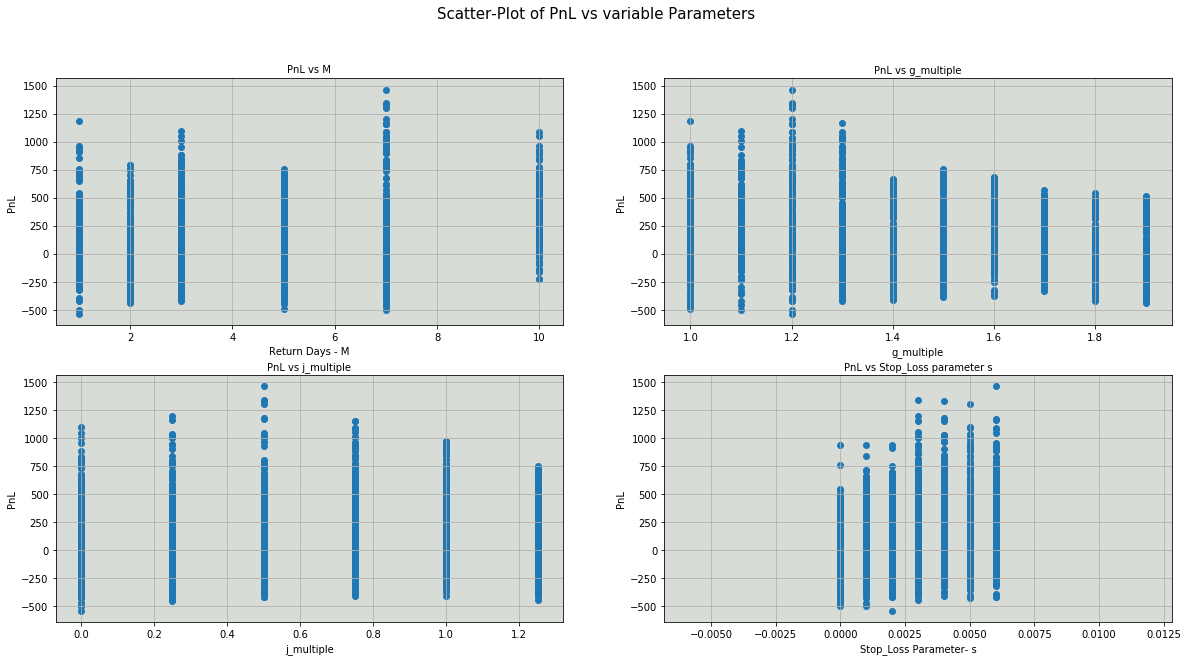

In [194]:
fig, ax = plt.subplots(nrows = 2,ncols = 2,figsize=(20, 10))
fig.suptitle('Scatter-Plot of PnL vs variable Parameters',fontsize = 15)

plt.subplot(2,2,1)
plt.scatter(c['M'],c['PnL'])
plt.title("PnL vs M",fontsize = 10)
plt.xlabel("Return Days - M")
plt.ylabel("PnL")
plt.grid(True)
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')

plt.subplot(2,2,2)
plt.scatter(c['g_multiple'],c['PnL'])
plt.title("PnL vs g_multiple",fontsize = 10)
plt.xlabel("g_multiple")
plt.ylabel("PnL")
plt.grid(True)
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')


plt.subplot(2,2,3)
plt.scatter(c['j_multiple'],c['PnL'])
plt.title("PnL vs j_multiple",fontsize = 10)
plt.xlabel("j_multiple")
plt.ylabel("PnL")
plt.grid(True)
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')


plt.subplot(2,2,4)
plt.scatter(c['Stop_Loss'],c['PnL'])
plt.title("PnL vs Stop_Loss parameter s",fontsize = 10)
plt.xlabel("Stop_Loss Parameter- s")
plt.ylabel("PnL")
plt.grid(True)
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')

plt.show()

### Boxplots of the results

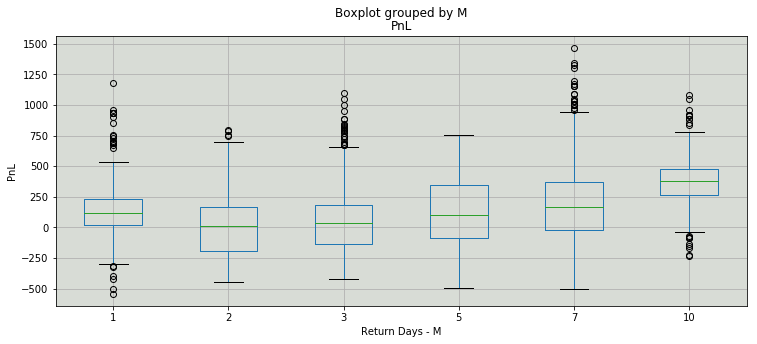

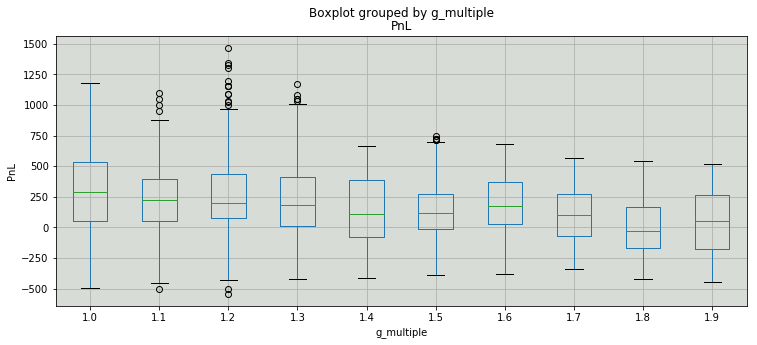

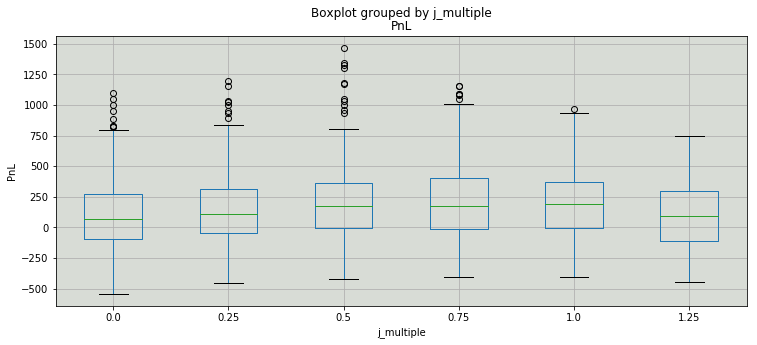

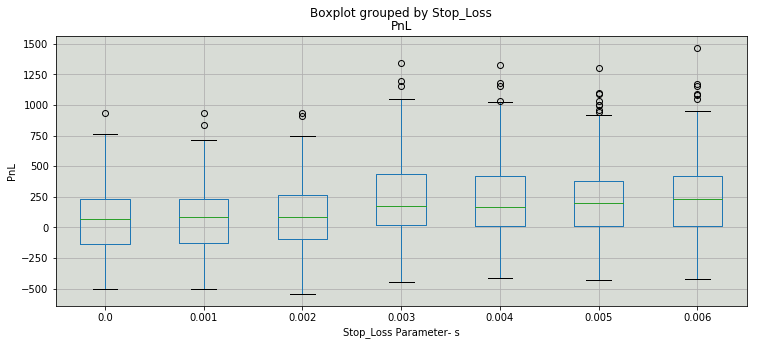

In [195]:
boxplot = c.boxplot(column=['PnL'], by='M',layout=(1, 1), figsize = (12,5), fontsize = 10)
plt.xlabel("Return Days - M")
plt.ylabel("PnL")
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')

boxplot = c.boxplot(column=['PnL'], by='g_multiple',layout=(1, 1), figsize = (12,5), fontsize = 10)
plt.xlabel("g_multiple")
plt.ylabel("PnL")
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')

boxplot = c.boxplot(column=['PnL'], by='j_multiple',layout=(1, 1),figsize = (12,5), fontsize = 10)
plt.xlabel("j_multiple")
plt.ylabel("PnL")
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')

boxplot = c.boxplot(column=['PnL'], by='Stop_Loss',layout=(1, 1) ,figsize = (12,5), fontsize = 10)
plt.xlabel("Stop_Loss Parameter- s")
plt.ylabel("PnL")
ax = plt.gca()
ax.set_facecolor('xkcd:light grey')

### Conclusions from the above box-plot

    1) From the return day box plot we observe that for 7 days most of the times the strategy is in profit and very low chances of losses and some probability of extreme profits as well.
    2) From the g_multiple plot it seems that the optimum g-level is 1.2, this seems reasonable because this allows for enough trading activities to take place to generate PnL from the strategy.
    3) From the j_multiple plot it seems that the optimum j-level is 0.5 becuse the profits seems reasonably stable around this level of j-multiple as this gives an optimal level of exit opportunities and we do not exit our positions too frequently.
    4) For the Stoploss parameter we can infer the Stop loss parameter value of 0.006 has the 25 quartile cappped at 0 which is the best out of all the StopLoss cases. Also the mean of profits is the highest amongst all the stop loss values.

#### Plot of the trading activities for a particular set of parameters

    1) Below I have changed the function to return a dataframe along with the PnL of the strategy to obtain the plot of trading activities and cumulative PnL from the strategy.
    2) Also I have show the PnL accumulation of the trading strategy and the return on capital below.

In [196]:
def Spread_Trading_Strategy_PnL(g_multiple,j_multiple,s,M):
    
    # g_multiple is the multiple of standard deviation for g parameter
    # j_multiple is the multiple of standard deviation for j parameter
    
    df = clean_quandl_columns(raw_data)
    
    df['Daily_Dollar_Volume_PBE'] = (df['PBE:Adj_Close']*df['PBE:Volume'])
    df['Daily_Dollar_Volume_XBI'] = (df['XBI:Adj_Close']*df['XBI:Volume'])
    
    # Our Current Holding of XBI and PBE ETFs in the market
    # Dollar Notional Size from the less liquid ETF (PBI in this case)
    df['Nt'] = df['Daily_Dollar_Volume_PBE'].rolling(15).median()
    
    # Computing M-day Returns and Returns Spread
    df['PBE_Daily_Return'] = (df['PBE:Adj_Close']/df['PBE:Adj_Close'].shift(M)) - 1
    df['XBI_Daily_Return'] = (df['XBI:Adj_Close']/df['XBI:Adj_Close'].shift(M)) - 1
    df['return_spread'] = df['PBE_Daily_Return'] - df['XBI_Daily_Return']                                            # x-y
    
    # Setting the levels of decision of entry and exit
    mu = 0
    std = df['return_spread'].std()
    gu = mu + g_multiple*std
    gl = mu + j_multiple*std
    jl = mu - g_multiple*std
    ju = mu - j_multiple*std
    
    #Slicing the data frame for the required period since our potential trade can start from 1st January 2017.
    df=df.loc["2017-01-01":"2018-12-31"]
    df=df[['PBE:Volume','PBE:Adj_Close','Daily_Dollar_Volume_PBE','PBE_Daily_Return','XBI:Volume','XBI:Adj_Close',
       'Daily_Dollar_Volume_XBI','XBI_Daily_Return','return_spread','Nt']]
    
    # Creating a Flag to check for month end date index
    x = pd.DataFrame(df.index,index = df.index).shift(-1)
    df['ME_Flag']=(x["Date"].dt.month != df.index.month)
    del x
    
    df["Final_Position"] = 0 * len(df.index)    # Final Position column indicates our current net market position of the spread.
    Final_Position = 0
    
    #Entry/Exit Criteria which updates the Final Spread Position in the market
    for i in range(len(df.index)):
        
        # At month end all the positions should be closed
        if (df.iat[i,10] == True):     
            Final_Position = 0
            df.iat[i,11] = Final_Position
            
            continue
            
        if ((df.iat[i,8] > gu) & (Final_Position != -1)):
            Final_Position = -1
            
        if ((df.iat[i,8] < gl) & (Final_Position == -1)):
            Final_Position = 0
            
        if ((df.iat[i,8] < jl) & (Final_Position != 1)):
            Final_Position = 1
            
        if ((df.iat[i,8] > ju) & (Final_Position == 1)):
            Final_Position = 0
            
        df.iat[i,11] = Final_Position
            
   # Spread Trade Quantity column indicates the spread trade quantity to be executed in the market to 
   # achieve the Final Position
    
    df['Spread_Trade_Quantity'] = df['Final_Position'] - df['Final_Position'].shift(1).fillna(0)
    df['Product_Position'] = df['Final_Position']*df['Spread_Trade_Quantity']
    
    df['PBE_shares_position'] = np.nan
    df['XBI_shares_position'] = np.nan
    df.loc[df['Product_Position'] != 0, 'PBE_shares_position'] = np.floor(df['Final_Position'] \
                                                                          * df['Nt']/(100*df['PBE:Adj_Close']))
    df.loc[df['Product_Position'] != 0,'XBI_shares_position'] = np.floor(-1 * df['Final_Position']\
                                                                         * df['Nt']/(100*df['XBI:Adj_Close']))
    df['PBE_shares_position'] = df['PBE_shares_position'].fillna(method = 'ffill')
    df['XBI_shares_position'] = df['XBI_shares_position'].fillna(method = 'ffill')
    df.loc[df['Final_Position'] == 0,'PBE_shares_position'] = 0
    df.loc[df['Final_Position'] == 0,'XBI_shares_position'] = 0
    
    # Stop Loss Level is determined on the basis of a proportion s of gross traded cash on trade date
    df['Stop_Loss_Level'] = np.nan
    df.loc[(df['Product_Position'] != 0) & (df['Final_Position'] != 0),'Stop_Loss_Level'] =  \
                -s * (abs(df['PBE_shares_position'])*df['PBE:Adj_Close'] + abs(df['XBI_shares_position'])*df['XBI:Adj_Close'])
    df['Stop_Loss_Level'] = df['Stop_Loss_Level'].fillna(method = 'ffill')
    
    # Initial Position column to compute the market value of our position when we assume a position in the market
    # Unrealized MtM column is the profit/loss accumulated in the position until we unwind the position.
    df['Initial_Position'] = np.nan
    df.loc[(df['Final_Position'] != 0)&(df['Spread_Trade_Quantity'] != 0),'Initial_Position'] = \
            (df['PBE_shares_position'])*df['PBE:Adj_Close'] + (df['XBI_shares_position'])*df['XBI:Adj_Close']
    df['Initial_Position'] = df['Initial_Position'].fillna(method = 'ffill')
    df['Net_Value'] = df['PBE_shares_position']*df['PBE:Adj_Close'] + df['XBI_shares_position']*df['XBI:Adj_Close']
    df['Unrealized_MtM'] = df['Net_Value'] - df['Initial_Position']
    
    # Determining if a stoploss level was hit in the month, in such case trading is stopped for the rest of the month
    df['stoploss_hit_indicator'] = 0 * len(df.index)
    
    index_label = df[((df['Unrealized_MtM'] < df['Stop_Loss_Level']))].index.tolist()

    for i in range(len(df.index)):
        if df.index[i] in index_label:
            df['stoploss_hit_indicator'][i] = df.index[i].month

    for i in range(len(df.index)-1):
        if df.index[i+1].month == df['stoploss_hit_indicator'][i]:
            df['stoploss_hit_indicator'][i+1] = df.index[i+1].month

    #Updating the Final_Position,Spread Trade Quantity,Product Position and share positions columns to 
    #account for the stoploss_hit_indicator
    
    df.loc[df['stoploss_hit_indicator'] != 0,"Final_Position"] = 0
    df['Spread_Trade_Quantity'] = df['Final_Position'] - df['Final_Position'].shift(1).fillna(0)
    df['Product_Position'] = df['Final_Position']*df['Spread_Trade_Quantity']
    df.loc[df['Product_Position'] != 0, 'PBE_shares_position'] = np.floor(df['Final_Position'] \
                                                                          * df['Nt']/(100*df['PBE:Adj_Close']))
    df.loc[df['Product_Position'] != 0,'XBI_shares_position'] = np.floor(-1 * df['Final_Position'] \
                                                                         * df['Nt']/(100*df['XBI:Adj_Close']))
    df.loc[df['Final_Position'] == 0 , 'PBE_shares_position'] = 0
    df.loc[df['Final_Position'] == 0, 'XBI_shares_position'] = 0
    df.loc[(df['Final_Position'] == 0) & (df['Spread_Trade_Quantity'] == 0),'Stop_Loss_Level'] = 0
    df.loc[(df['Final_Position'] == 0) & (df['Spread_Trade_Quantity'] == 0),'Initial_Position'] = 0
    df.loc[(df['Final_Position'] == 0) & (df['Spread_Trade_Quantity'] == 0),'Net_Value'] = 0
    df['PBE_shares_position'] = df['PBE_shares_position'].fillna(method = 'ffill')
    df['XBI_shares_position'] = df['XBI_shares_position'].fillna(method = 'ffill')
    
    # Quantity of PBE and XBI shares that need to be traded to achieve the current market position
    df['PBE_shares_position_diff'] = df['PBE_shares_position']-df['PBE_shares_position'].shift(1).fillna(0)
    df['XBI_shares_position_diff'] = df['XBI_shares_position']-df['XBI_shares_position'].shift(1).fillna(0)
    df['Initial_Position'] = df['Initial_Position'].fillna(method = 'ffill')
    df['Unrealized_MtM'] = df['Net_Value'] - df['Initial_Position']
    
    # Computing the PnL of the strategy
    df['CashI/O'] = 0.0 * len(df.index)
    df['CashI/O'] = -df['PBE_shares_position_diff']*df['PBE:Adj_Close']-df['XBI_shares_position_diff']*df['XBI:Adj_Close']
    df['PnL'] = df['CashI/O'].cumsum()
    
    Final_Profit_from_strategy = df['PnL'][-1] 
    
    return (Final_Profit_from_strategy,df)

### Plot of Trading Points

C:\Users\Anshul\Anaconda3\envs\Quant_Trading_Strategies\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Anshul\Anaconda3\envs\Quant_Trading_Strategies\lib\site-packages\ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Profit from the strategy 1464.266695156959
Level 1 0.02 Level 2 0.008 Level 3 -0.008 Level 4 -0.02


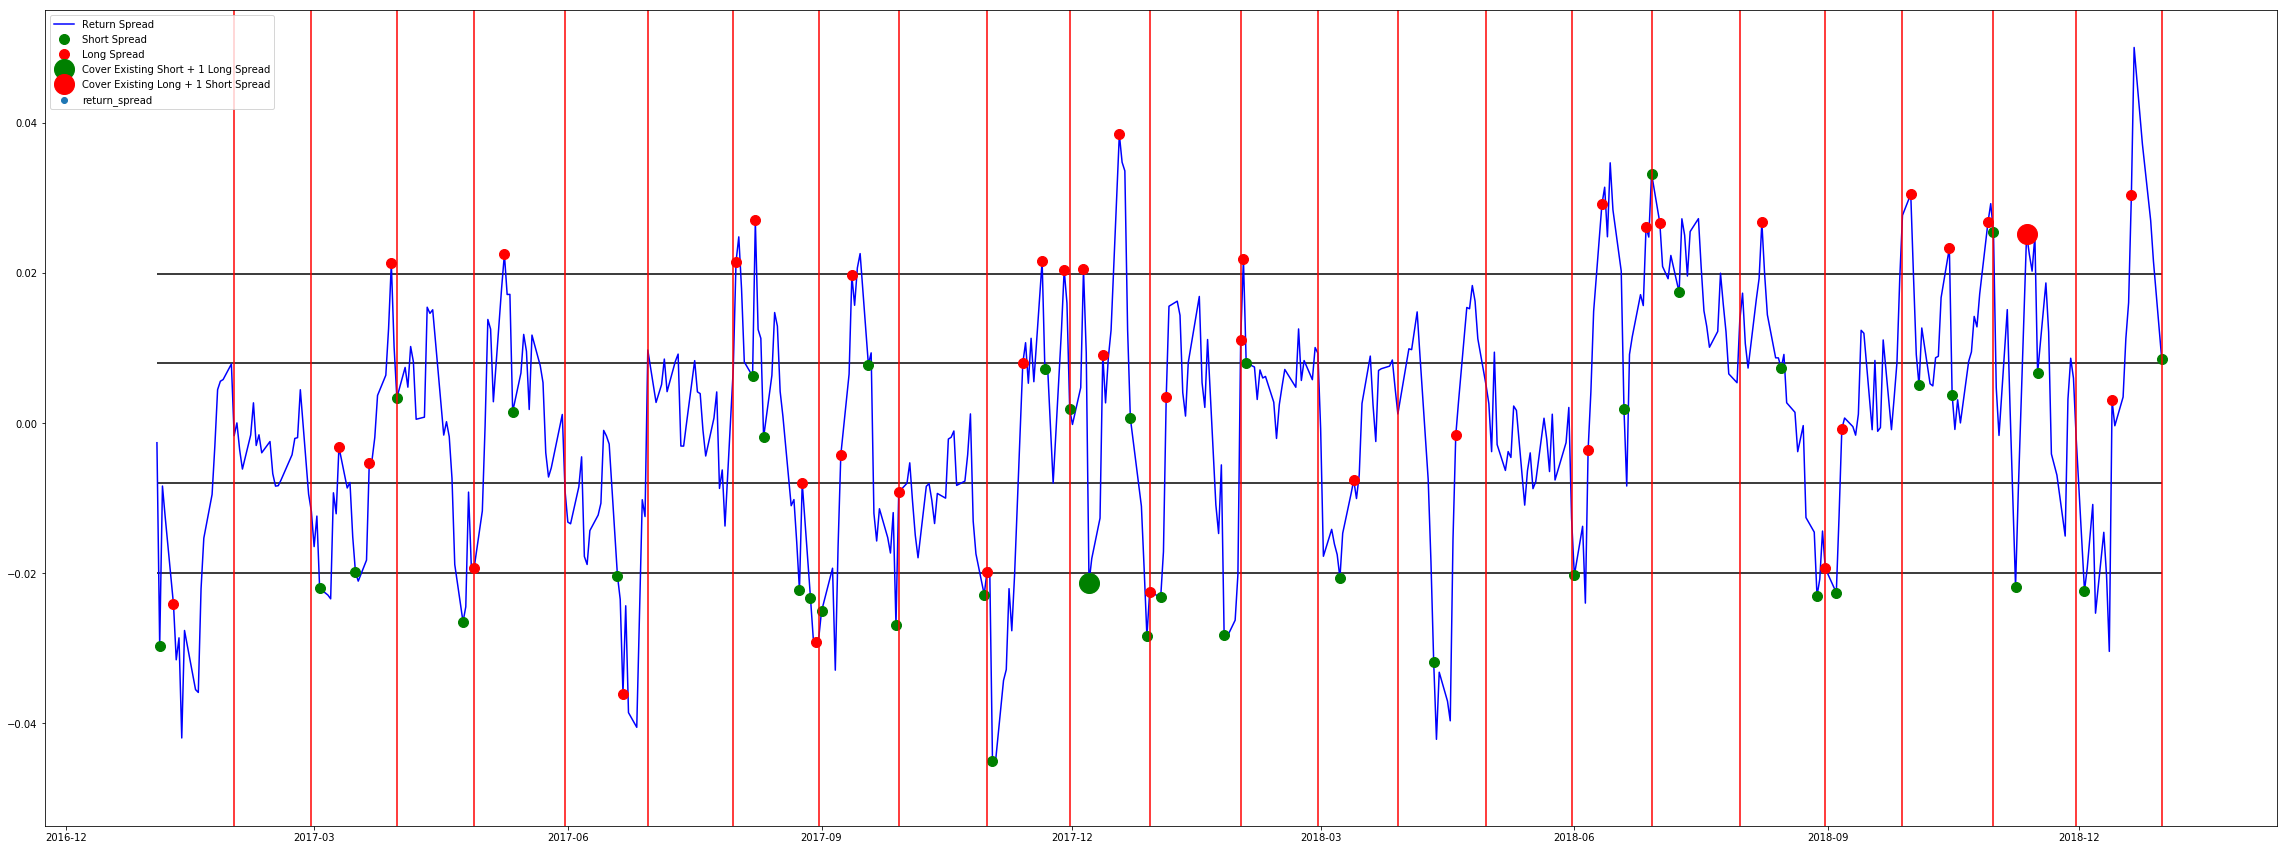

In [197]:
a,d = Spread_Trading_Strategy_PnL(1.2,0.5,0.006,7)
mu = 0
std = d['return_spread'].std()
gu = mu + 1.25*std
gl = mu + 0.5*std
jl = mu - 1.25*std
ju = mu - 0.5*std
print("Profit from the strategy",a)
print("Level 1 " + str(round(gu,4)) +  " Level 2 " + str(round(gl,4)) +  " Level 3 " + str(round(ju,4)) + " Level 4 " + str(round(jl,4)))
long = d.loc[d['Spread_Trade_Quantity'] == 1]
short = d.loc[d['Spread_Trade_Quantity'] == -1]
long2 = d.loc[d['Spread_Trade_Quantity'] == 2]
short2 = d.loc[d['Spread_Trade_Quantity'] == -2]
fig = plt.figure(figsize = (40,15))
ax = fig.add_subplot(111)
ax.scatter(long.index, long['return_spread'])
plt.plot(d.index, d['return_spread'], 'b-',label = 'Return Spread')
plt.plot(long.index, long['Spread_Trade_Quantity']*long['return_spread'],'ro',color="green",markersize=10,label = 'Short Spread')
plt.plot(short.index, (-1)*short['Spread_Trade_Quantity']*short['return_spread'],'ro',color="red",markersize=10, label = 'Long Spread')
plt.plot(long2.index, (1/2)*long2['Spread_Trade_Quantity']*long2['return_spread'],'ro',color="green",markersize=20, label = 'Cover Existing Short + 1 Long Spread')
plt.plot(short2.index, (-1/2)*short2['Spread_Trade_Quantity']*short2['return_spread'],'ro',color="red",markersize=20, label = 'Cover Existing Long + 1 Short Spread')

x_min,x_max=d.index[0],d.index[-1]
plt.hlines(gu,x_min,x_max)
plt.hlines(gl,x_min,x_max)
plt.hlines(ju,x_min,x_max)
plt.hlines(jl,x_min,x_max)
ax.legend()
index_label = d[((d['ME_Flag'] == True))].index.tolist()

for i in index_label:
    plt.axvline(x = i, color='r', linestyle='-',label = 'month end dates')

plt.show()

#### Conclusion
    1) The above plot shows the trading activities that took place during the dataset period , the red vertical lines are makrers for the month end dates. I close the positions at the end of the month. Vertical lines show the month end dates.

### Accumulated PnL plot for one set of parameters

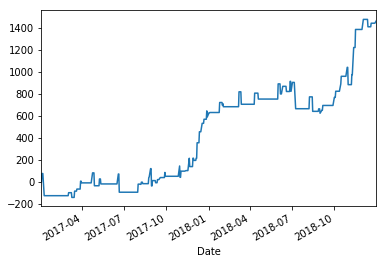

In [198]:
d['PnL'].plot()
plt.show()

### Return on Capital

In [206]:
K = 2 * np.max(d['Nt'])
Return_on_Capital = (a/K)*100
print("Return on capital is "+ str(Return_on_Capital)+ " % ") 

Return on capital is 0.03622795716076542 % 


In [207]:
d['return_spread'].std()

0.01596022688602309

#### Conclusion
    1) Return on capital is 0.033%.
    2) Optimal g-value is 1.2*std = 1.2*0.01596 = 0.01915
    3) Optimal j-value is 0.5*std = 0.5*0.01596 = 0.00798
    4) Optimal stop loss parameter = 0.6 % of Gross Traded Cash
    5) Optimal number of Return Days = 7